## Import package

In [1]:
from __future__ import division
    
import numpy as np
import pandas as pd
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from imblearn.over_sampling import ADASYN, SMOTE

## Load dataset: Train

In [2]:
train = pd.read_csv("../../../../../data/train/train.csv")
test = pd.read_csv("../../../../../data/test/test.csv")

In [3]:
print(train.shape)
print(test.shape)

(9557, 143)
(23856, 142)


In [4]:
train.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [5]:
test.head(5)

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,ID_2f6873615,NaN,0,5,0,1,1,0,NaN,1,...,4,0,16,9,0,1,2.25,0.25,272.25,16
1,ID_1c78846d2,NaN,0,5,0,1,1,0,NaN,1,...,41,256,1681,9,0,1,2.25,0.25,272.25,1681
2,ID_e5442cf6a,NaN,0,5,0,1,1,0,NaN,1,...,41,289,1681,9,0,1,2.25,0.25,272.25,1681
3,ID_a8db26a79,NaN,0,14,0,1,1,1,1.0,0,...,59,256,3481,1,256,0,1.00,0.00,256.00,3481
4,ID_a62966799,175000.0,0,4,0,1,1,1,1.0,0,...,18,121,324,1,0,1,0.25,64.00,NaN,324


In [6]:
f = open("../../../resources/continuousFeatures", "r")
continuous_columns = f.read().split(",")
f.close()

f = open("../../../resources/categoricalFeatures", "r")
categorical_columns = f.read().split(",")
f.close()

f = open("../../../resources/yesNoFeaturesNames", "r")
yes_no_columns = f.read().split(",")
f.close()

print("Number of numerical columns: {0}".format(len(continuous_columns)))
print("Number of categorical columns: {0}".format(len(categorical_columns)))
print("Number of yes/no columns: {0}".format(len(yes_no_columns)))

Number of numerical columns: 38
Number of categorical columns: 102
Number of yes/no columns: 3


In [7]:
category, category_ount = np.unique(train["Target"], return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_ount)))

(Category, Count): [(1, 755), (2, 1597), (3, 1209), (4, 5996)]


## Fil Yes/No values

In [8]:
# yes=1 and no=0
def fill_yes_no(value):
    if value == "yes":
        return 1.0
    elif value == "no":
        return 0.0
    else:
        return float(value)

In [9]:
for column in yes_no_columns:
    train["new_{0}".format(column)] = train.apply(lambda row: fill_yes_no(row[column]), axis=1)
    test["new_{0}".format(column)] = test.apply(lambda row: fill_yes_no(row[column]), axis=1)

train = train.drop(yes_no_columns, axis=1)
test = test.drop(yes_no_columns, axis=1)

columns={"new_{0}".format(column): column for column in yes_no_columns}
train = train.rename(index=str, columns=columns)
test = test.rename(index=str, columns=columns)

## Fill Nan values

In [10]:
null_columns = train.isnull().any()

In [11]:
null_columns = train.columns[train.isnull().any()].tolist() ## continuous variables
null_columns

['v2a1', 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']

In [12]:
train[["Target","v2a1", 'v18q1', 'rez_esc', 'meaneduc', 'SQBmeaned']].head()

,Target,v2a1,v18q1,rez_esc,meaneduc,SQBmeaned
0,4,190000.0,NaN,NaN,10.0,100.0
1,4,135000.0,1.0,NaN,12.0,144.0
2,4,NaN,NaN,NaN,11.0,121.0
3,4,180000.0,1.0,1.0,11.0,121.0
4,4,180000.0,1.0,NaN,11.0,121.0


In [13]:
label_mean = train[null_columns].mean()
# label_mean.to_dict()

In [14]:
label_mean

v2a1         165231.606971
v18q1             1.404063
rez_esc           0.459791
meaneduc          9.231523
SQBmeaned       102.588867
dtype: float64

In [15]:
for column in null_columns:
    train["new_{0}".format(column)] = train.apply(
    lambda row: label_mean[column] if np.isnan(row[column]) else row[column],
    axis=1)
    
    test["new_{0}".format(column)] = test.apply(
    lambda row: label_mean[column] if np.isnan(row[column]) else row[column],
    axis=1)    

train = train.drop(null_columns, axis=1)
test = test.drop(null_columns, axis=1)
train = train.rename(index=str, columns={"new_{0}".format(column): column for column in null_columns})
test = test.rename(index=str, columns={"new_{0}".format(column): column for column in null_columns})

## Standard scaled

In [16]:
from sklearn.preprocessing import StandardScaler
estimator = StandardScaler(copy=True, with_mean=True, with_std=True)
model = estimator.fit(train[continuous_columns])
X_scaled = model.transform(train[continuous_columns])
x_test_scaled = model.transform(test[continuous_columns])

## Train - Validation split

In [17]:
# X_train, X_validation, y_train, y_validation = train_test_split(X_scaled, train["Target"], test_size=0.2, stratify=train["Target"])
X_train, X_validation, y_train, y_validation = train_test_split(X_scaled, train["Target"], test_size=0.2, stratify=train["Target"])

In [18]:
print(X_train.shape, y_train.shape)
print(X_validation.shape, y_validation.shape)

((7645, 38), (7645,))
((1912, 38), (1912,))


In [19]:
category, category_count = np.unique(y_train, return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_count)))
      
category, category_count = np.unique(y_validation, return_counts=True)
print("(Category, Count): {0}".format(zip(category, category_count)))     

(Category, Count): [(1, 604), (2, 1278), (3, 967), (4, 4796)]
(Category, Count): [(1, 151), (2, 319), (3, 242), (4, 1200)]


## Balanced datasets - SMOTE

In [20]:
smo = SMOTE(kind="svm")
X_resampled, y_resampled = smo.fit_sample(X_train, y_train)

## Utilities functions

In [21]:
def all_score(y_true, y_prediction):
    accuracy = accuracy_score(y_true, y_prediction)
    precision = precision_score(y_true, y_prediction, average="macro")
    recall = recall_score(y_true, y_prediction, average="macro")
    f1 = f1_score(y_true, y_prediction, average="macro")
    return accuracy, precision, recall, f1

In [22]:
def print_score(accuracy, precision, recall, f1):
    print('Accuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1:', f1)

## Classifier: ExtraTreesClassifier

### n_estimators

In [23]:
scores_train = {"accuracy": [], "precision": [], 
          "recall": [], "f1": []}
scores_validation = {"accuracy": [], "precision": [], 
          "recall": [], "f1": []}
estimators = [10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [24]:
print("estimator: ")
for n_estimator in estimators:
    print("{0} ".format(n_estimator)),
    estimator = ExtraTreesClassifier(n_estimators=n_estimator)
    model = estimator.fit(X_resampled, y_resampled)
    
    prediction_resampled = model.predict(X_resampled)
    accuracy, precision, recall, f1 = all_score(y_resampled, prediction_resampled)
    scores_train["accuracy"].append(accuracy) 
    scores_train["precision"].append(precision)
    scores_train["recall"].append(recall)
    scores_train["f1"].append(f1)
    
    prediction_validation = model.predict(X_validation)
    accuracy, precision, recall, f1 = all_score(y_validation, prediction_validation)
    scores_validation["accuracy"].append(accuracy) 
    scores_validation["precision"].append(precision)
    scores_validation["recall"].append(recall)
    scores_validation["f1"].append(f1)

estimator: 
10  50  100  200  300  400  500  600  700  800  900  1000 


# scores

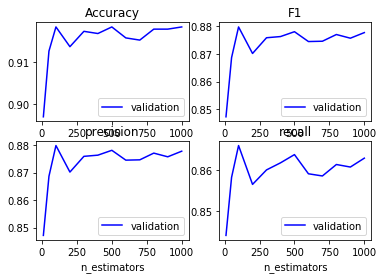

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=2)

# ax[0][0].plot(estimators, scores_train["accuracy"], c="r", label="train")
ax[0][0].plot(estimators, scores_validation["accuracy"], c="b", label="validation")
ax[0][0].set_xlabel("n_estimators")
ax[0][0].set_title("Accuracy")
ax[0][0].legend() 

# ax[0][1].plot(estimators, scores_train["f1"], c="r", label="train")
ax[0][1].plot(estimators, scores_validation["f1"], c="b", label="validation")
ax[0][1].set_xlabel("n_estimators")
ax[0][1].set_title("F1")
ax[0][1].legend()

# ax[1][0].plot(estimators, scores_train["precision"], c="r", label="train")
ax[1][0].plot(estimators, scores_validation["f1"], c="b", label="validation")
ax[1][0].set_xlabel("n_estimators")
ax[1][0].set_title("precision")
ax[1][0].legend()

# ax[1][1].plot(estimators, scores_train["recall"], c="r", label="train")
ax[1][1].plot(estimators, scores_validation["recall"], c="b", label="validation")
ax[1][1].set_xlabel("n_estimators")
ax[1][1].set_title("recall")
ax[1][1].legend()

### min_samples_split

In [26]:
scores_train = {"accuracy": [], "precision": [], 
          "recall": [], "f1": []}
scores_validation = {"accuracy": [], "precision": [], 
          "recall": [], "f1": []}
splits = [2, 3, 4, 5, 6, 7, 8, 9]

In [27]:
print("split: ")
for split in splits:
    print("{0} ".format(split)),
    estimator = ExtraTreesClassifier(n_estimators=200, 
                                     min_samples_split=split)
    model = estimator.fit(X_resampled, y_resampled)
    
    prediction_resampled = model.predict(X_resampled)
    accuracy, precision, recall, f1 = all_score(y_resampled, prediction_resampled)
    scores_train["accuracy"].append(accuracy) 
    scores_train["precision"].append(precision)
    scores_train["recall"].append(recall)
    scores_train["f1"].append(f1)
    
    prediction_validation = model.predict(X_validation)
    accuracy, precision, recall, f1 = all_score(y_validation, prediction_validation)
    scores_validation["accuracy"].append(accuracy) 
    scores_validation["precision"].append(precision)
    scores_validation["recall"].append(recall)
    scores_validation["f1"].append(f1)

split: 
2  3  4  5  6  7  8  9 


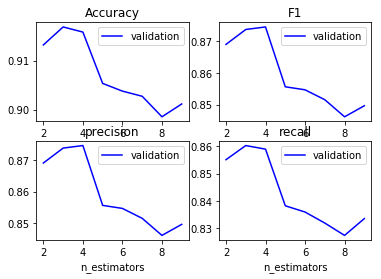

In [28]:
fig, ax = plt.subplots(nrows=2, ncols=2)

# ax[0][0].plot(estimators, scores_train["accuracy"], c="r", label="train")
ax[0][0].plot(splits, scores_validation["accuracy"], c="b", label="validation")
ax[0][0].set_xlabel("n_estimators")
ax[0][0].set_title("Accuracy")
ax[0][0].legend() 

# ax[0][1].plot(estimators, scores_train["f1"], c="r", label="train")
ax[0][1].plot(splits, scores_validation["f1"], c="b", label="validation")
ax[0][1].set_xlabel("n_estimators")
ax[0][1].set_title("F1")
ax[0][1].legend()

# ax[1][0].plot(estimators, scores_train["precision"], c="r", label="train")
ax[1][0].plot(splits, scores_validation["f1"], c="b", label="validation")
ax[1][0].set_xlabel("n_estimators")
ax[1][0].set_title("precision")
ax[1][0].legend()

# ax[1][1].plot(estimators, scores_train["recall"], c="r", label="train")
ax[1][1].plot(splits, scores_validation["recall"], c="b", label="validation")
ax[1][1].set_xlabel("n_estimators")
ax[1][1].set_title("recall")
ax[1][1].legend()

### min_samples_leaf

In [29]:
scores_train = {"accuracy": [], "precision": [], 
          "recall": [], "f1": []}
scores_validation = {"accuracy": [], "precision": [], 
          "recall": [], "f1": []}
leafs = [2, 3, 4, 5, 6, 7, 8, 9]

In [30]:
print("leaf: ")
for leaf in leafs:
    print("{0} ".format(leaf)),
    estimator = ExtraTreesClassifier(n_estimators=200, 
                                     min_samples_split=3,
                                     min_samples_leaf=leaf)
    model = estimator.fit(X_resampled, y_resampled)
    
    prediction_resampled = model.predict(X_resampled)
    accuracy, precision, recall, f1 = all_score(y_resampled, prediction_resampled)
    scores_train["accuracy"].append(accuracy) 
    scores_train["precision"].append(precision)
    scores_train["recall"].append(recall)
    scores_train["f1"].append(f1)
    
    prediction_validation = model.predict(X_validation)
    accuracy, precision, recall, f1 = all_score(y_validation, prediction_validation)
    scores_validation["accuracy"].append(accuracy) 
    scores_validation["precision"].append(precision)
    scores_validation["recall"].append(recall)
    scores_validation["f1"].append(f1)

leaf: 
2  3  4  5  6  7  8  9 


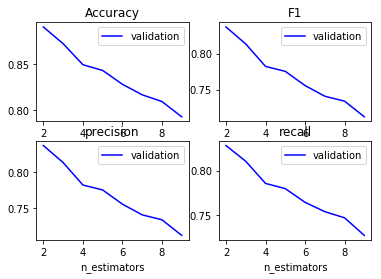

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2)

# ax[0][0].plot(estimators, scores_train["accuracy"], c="r", label="train")
ax[0][0].plot(leafs, scores_validation["accuracy"], c="b", label="validation")
ax[0][0].set_xlabel("n_estimators")
ax[0][0].set_title("Accuracy")
ax[0][0].legend() 

# ax[0][1].plot(estimators, scores_train["f1"], c="r", label="train")
ax[0][1].plot(leafs, scores_validation["f1"], c="b", label="validation")
ax[0][1].set_xlabel("n_estimators")
ax[0][1].set_title("F1")
ax[0][1].legend()

# ax[1][0].plot(estimators, scores_train["precision"], c="r", label="train")
ax[1][0].plot(leafs, scores_validation["f1"], c="b", label="validation")
ax[1][0].set_xlabel("n_estimators")
ax[1][0].set_title("precision")
ax[1][0].legend()

# ax[1][1].plot(estimators, scores_train["recall"], c="r", label="train")
ax[1][1].plot(leafs, scores_validation["recall"], c="b", label="validation")
ax[1][1].set_xlabel("n_estimators")
ax[1][1].set_title("recall")
ax[1][1].legend()

### max_depth

In [32]:
scores_train = {"accuracy": [], "precision": [], 
          "recall": [], "f1": []}
scores_validation = {"accuracy": [], "precision": [], 
          "recall": [], "f1": []}
depths = [1, 5, 10, 15, 20, 25, 30, 35, 40]

In [33]:
print("depth: ")
for depth in depths:
    print("{0} ".format(depth)),
    estimator = ExtraTreesClassifier(n_estimators=200, 
                                     min_samples_split=3,
                                     min_samples_leaf=2,
                                     max_depth=depth)
    model = estimator.fit(X_resampled, y_resampled)
    
    prediction_resampled = model.predict(X_resampled)
    accuracy, precision, recall, f1 = all_score(y_resampled, prediction_resampled)
    scores_train["accuracy"].append(accuracy) 
    scores_train["precision"].append(precision)
    scores_train["recall"].append(recall)
    scores_train["f1"].append(f1)
    
    prediction_validation = model.predict(X_validation)
    accuracy, precision, recall, f1 = all_score(y_validation, prediction_validation)
    scores_validation["accuracy"].append(accuracy) 
    scores_validation["precision"].append(precision)
    scores_validation["recall"].append(recall)
    scores_validation["f1"].append(f1)

depth: 
1  5  10  15  20  25  30  35  40 


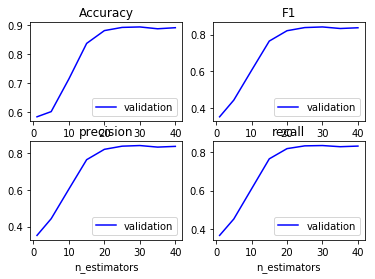

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2)

# ax[0][0].plot(estimators, scores_train["accuracy"], c="r", label="train")
ax[0][0].plot(depths, scores_validation["accuracy"], c="b", label="validation")
ax[0][0].set_xlabel("n_estimators")
ax[0][0].set_title("Accuracy")
ax[0][0].legend() 

# ax[0][1].plot(estimators, scores_train["f1"], c="r", label="train")
ax[0][1].plot(depths, scores_validation["f1"], c="b", label="validation")
ax[0][1].set_xlabel("n_estimators")
ax[0][1].set_title("F1")
ax[0][1].legend()

# ax[1][0].plot(estimators, scores_train["precision"], c="r", label="train")
ax[1][0].plot(depths, scores_validation["f1"], c="b", label="validation")
ax[1][0].set_xlabel("n_estimators")
ax[1][0].set_title("precision")
ax[1][0].legend()

# ax[1][1].plot(estimators, scores_train["recall"], c="r", label="train")
ax[1][1].plot(depths, scores_validation["recall"], c="b", label="validation")
ax[1][1].set_xlabel("n_estimators")
ax[1][1].set_title("recall")
ax[1][1].legend()

## Test submission

In [35]:
X = test[continuous_columns]

In [36]:
estimator = ExtraTreesClassifier(n_estimators=200, 
                                     min_samples_split=3,
                                     min_samples_leaf=2,
                                     max_depth=25)
model = estimator.fit(X_resampled, y_resampled)
prediction = model.predict(x_test_scaled)

In [37]:
id_kaggle = test["Id"]
d = {"Id": id_kaggle, "Target": prediction}
data = pd.DataFrame(d)

In [38]:
data.head(3)

,Id,Target
0,ID_2f6873615,4
1,ID_1c78846d2,4
2,ID_e5442cf6a,4


In [39]:
data.groupby(["Target"]).count()

,Id
Target,
1,1322
2,4106
3,2197
4,16231


In [40]:
data.to_csv("submission.csv", index=False)